# 期末主題 1 - 浣熊與袋鼠辨識模型
## 專案⽬標：

本次期末專題主題建立⼀個模型同時能辨識出浣熊(raccoon)與袋鼠(kangaroo)的類別與位置。



#1. 確認執行環境 -  查看 GPU 資訊

In [1]:
!nvidia-smi

Sat May 16 13:24:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 1.1 使用Day041 -範例
參考 `train.py` 實現的訓練模型程式碼範例，確認tensorflow版本與安裝指定keras版本


In [2]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [3]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
import os
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
# 此處為google drive中的文件路徑，drive為之前指定的工作跟目錄，要加上位置
# 如果存放的路徑有變，從/content/drive/My Drive/XXXXX...做調整
path = "/content/gdrive/My Drive/深度學習與電腦視覺學習馬拉松-第二屆/Day_49-50/YOLOFinalProject"
os.chdir(path)  #os.chdir():改變當前工作目錄到指定的路徑。
# %cd keras-yolo3
!ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
 annotation_xml         kmeans.py	      trained_weights_stage_1.png
 class.txt	        LICENSE		      train_labels.txt
 coco_annotation.py     logs		      train.py
 convert.py	        mAP		      val_labels.txt
 darknet53.cfg	        model_data	      video
 Final_Loss.png         __pycache__	      yolo3
'Final Project.ipynb'   raccoon_dataset       yolo.py
 font		        README.md	      yolov3.cfg
 images		        Test		      yolov3-tiny.cfg
 Initial_Loss.png       train		      yolov3.weights
 kangaroo	        train_bottleneck.py   yolo_video.py


## 1.2 下載訓練用的權重(weights)

In [5]:
import os
if not os.path.exists( "/content/gdrive/My Drive/深度學習與電腦視覺學習馬拉松-第二屆/Day_49-50/YOLOFinalProject/model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


##1.3 下載資料檔

In [6]:
# 直接下載 raccoon_dataset 的資料集
if not os.path.exists("raccoon_dataset"):
  os.system("wget https://github.com/experiencor/raccoon_dataset") # 下載 raccoon_dataset 資料集
else:
  print("raccoon_dataset exists")
# 直接下載 kangaroo 的資料集
if not os.path.exists("kangaroo"):
  os.system("wget https://github.com/experiencor/kangaroo") # 下載 kangaroo 資料集
else:
  print("kangaroo exists")

raccoon_dataset exists
kangaroo exists


# 2. 將圖檔分類並轉換資料格式
參考 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，將資料進行資料型態的轉換，另外參考https://github.com/andyhu00/1st-DL-CVMarathon/blob/master/1st-DL-CVMarathon_project.ipynb 將資料集進行整理與分類。


參考來源: https://absentm.github.io/2016/06/14/%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0%E4%B8%AD%E7%9A%84Data-Augmentation%E6%96%B9%E6%B3%95%E5%92%8C%E4%BB%A3%E7%A0%81%E5%AE%9E%E7%8E%B0/


In [7]:
import numpy as np
# 訓練模型時需使用的 annotation 檔名, 若已經做好轉換, 則不會每次再重新跑這段轉換的程式碼
if not os.path.exists("train_labels.txt"):
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  #os.listdir() 方法用于返回指定的文件夹包含的文件或文件夹的名字的列表
   # 數據集
  sets=['train', 'val'] # 此處可以替換為自己的數據集

  # "raccoon", "kangaroo" 的資料類別
  # Pascal VOC 的資料類別 
  # classes = [] 此處可以修改為自己的類別
  # 要檢測的類別
  classes = ["raccoon", "kangaroo"]

  # 把 annotation(.xml) 轉換到訓練時需要的資料形態
  def convert_annotation(image_id, list_file):
      in_file = open('annotation_xml/%s.xml'%(image_id)) # 將數據集放於當前目錄下，要讀取的數據集中的注釋文件，是XML格式
      tree=ET.parse(in_file)
      root = tree.getroot()

      for obj in root.iter('object'): # 檢測到的對象節點
          difficult = obj.find('difficult').text #從注釋文件中獲得difficult
          cls = obj.find('name').text # 從注釋文件件中獲得"類别名稱"
          if cls not in classes or int(difficult)==1: 
              continue
          cls_id = classes.index(cls)  # class index # 獲得這個類別名稱，在上面的classes中的位置序號
          xmlbox = obj.find('bndbox') # 檢測框節點
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), 
                int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))
  
  # 確認總共有多少的data
  # 把 raccoon_dataset/images 與 kangaroo/images 檔案合併後, 當成訓練集 & 驗證集資料
  for root_r,dirs_r,files_r in os.walk('raccoon_dataset/images') :  #os.walk():搜索所有的資料夾
    print("raccon 目錄:",root_r)
    print('raccoon 檔案數量:', len(files_r))
  print() # 空一行
  for root_k,dirs_k,files_k in os.walk('kangaroo/images') :
    print("kangaroo 目錄:",root_k)
    print('kangaroo 檔案數量:', len(files_k))
  # 合併 racoon 與 kangaroo 的資料
  datasets = files_r + files_k
  print('合併後所有 jpg 檔數量:', len(datasets))
  datasets_ids = ''.join(datasets).strip().split('.jpg')[:-1]
  #strip():從開始或結束的字符串被刪除去除。
  #split()：拆分字符串。通過指定分隔符對字符串進行切片
  print(datasets_ids)
    
  # 80% 檔案資料當成訓練集資料
  train_data = np.random.choice( datasets_ids, size=int(len( datasets_ids)*0.8), replace=False)
  val_data = np.setdiff1d( datasets_ids, train_data)
  """
  np.random.choice(a, size=None, replace=True, p=None)
  可以从一个int數字或1维array裡隨機選取内容，並且將選取結果放入n維array中返回。
  從a中以概率P，隨機選擇size, 不可以重複
  np.setdiff1d(x,y)
  使用setdiff1d输出在x中不在y中的元素
  """

  !mkdir train val #建立資料夾
  # 把訓練集資料放入 train 資料夾
  train_txt = open('train/train.txt', 'w') #打開檔案,開啟寫入模式
  print("save train index at train/train.txt")       
  for train_id in train_data : 
      train_txt.write('%s' %(train_id)) #寫入每一筆訓練資料的id
      train_txt.write('\n') #換行
  train_txt.close() #關閉檔案
  # 把驗證集資料放入 val 資料夾
  val_txt = open('val/val.txt', 'w') #打開檔案,開啟寫入模式
  print("save val index at val/val.txt")       
  for val_id in val_data : 
      val_txt.write('%s' %(val_id)) #寫入每一筆訓練資料的id
      val_txt.write('\n') #換行
  val_txt.close() #關閉檔案

  # 把annotation(.xml), 放入 annotation_xml 資料夾
  !mkdir annotation_xml
  !cp raccoon_dataset/annotations/*.xml ./annotation_xml
  !cp kangaroo/annots/*.xml ./annotation_xml

  # 把類別資料放入 class.txt
  class_txt = open('class.txt', 'w')
  print("save class at class.txt")       
  for class_id in classes : 
      class_txt.write('%s' %(class_id)) #寫入每一筆類別資料
      class_txt.write('\n')  #換行
  class_txt.close() #關閉檔案

  for image_set in sets:
      image_ids = open('%s/%s.txt'%(image_set, image_set)).read().strip().split()
      
      annotation_path = '%s_labels.txt'%(image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)
      # 處理訓練集 & 驗證集資料檔
      for image_id in image_ids:
        if 'raccoon' in image_id :
          list_file.write('./raccoon_dataset/images/%s.jpg' %(image_id))
        else :
          list_file.write('./kangaroo/images/%s.jpg' %(image_id))  
        convert_annotation(image_id, list_file)
        list_file.write('\n')
      list_file.close()
else:
  print('annotation data is existed!!')

annotation data is existed!!


# 3. 準備訓練
## 3.1 載入訓練所需要之相關套件

In [8]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [9]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


##3.2.1 第一階段訓練辨識模型

此部分主要沿用Day041課程範例的內容，首先訓練第一階段

Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 291 samples, val on 73 samples, with batch size 16.
Epoch 1/100
18/18 [==============================] - 32s 2s/step - loss: 3207.4943 - val_loss: 919.5387
Epoch 2/100
18/18 [==============================] - 21s 1s/step - loss: 562.1782 - val_loss: 301.9782
Epoch 3/100
18/18 [==============================] - 23s 1s/step - loss: 253.5294 - val_loss: 170.4925
Epoch 4/100
18/18 [==============================] - 23s 1s/step - loss: 168.7089 - val_loss: 136.6180
Epoch 5/100
18/18 [==============================] - 22s 1s/step - loss: 133.2516 - val_loss: 106.7169
Epoch 6/100
18/18 [==============================] - 10s 555ms/step - loss: 113.1267 - val_loss: 90.2721
Epoch 7/100
18/18 [==============================] - 22s 1s/step - loss: 94.3557 - val_loss: 77.9212
Epoch 8/100
18/18 [==============================] - 22s 1s/step - loss: 81.5736 - val_loss: 68.8965
Epoch 9/100
18/18 [=======

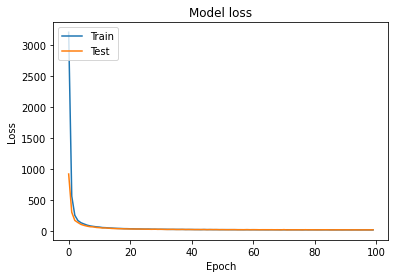

In [0]:
annotation_path_train = 'train_labels.txt' # 轉換好格式的訓練檔案
annotation_path_val = 'val_labels.txt' # 轉換好格式的驗證檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'class.txt' #自定義標籤檔路徑及名稱
anchors_path = 'model_data/yolo_anchors.txt' #錨點定義檔路徑及名稱
class_names = get_classes(classes_path) 
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
                              freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
                        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir) # TensorBoard可視化工具
# save_weights_only只儲存權重，save_best_only只儲存最優結果
# 每隔3個epoch儲存一次
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)  # 降低學習率，學習率每次為0.1，當學習率三次未减少時就停止，verbose為1，顯示進度條。
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1) # 驗證集準確率，當驗證集準確率連續增加小於（min_delta）時，連續10個epoch，則終止訓練。

# 分為 training 以及 validation
# 樣本數量：數據被拆10份
with open(annotation_path_train) as f:
    lines_train = f.readlines()
with open(annotation_path_val) as f:
    lines_val = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines_train)# 隨機打亂樣本
np.random.shuffle(lines_val)# 隨機打亂樣本
np.random.seed(None)
num_train = len(lines_train)  # 訓練資料(80%)
num_val = len(lines_val)      # 驗證資料(20%)

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
# 第一階段，凍結部分網路，只訓練底層權重
if True:
    # 配置模型訓練(優化器為Adam，損失函數(目標函數))
    model.compile(optimizer=Adam(lr = 1e-3,decay = 0.0,epsilon = None), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})  # 損失函數，使用定制的 yolo_loss Lambda層，Adam是基於一個梯度来優化隨機目標函数的算法，optimizer是優化器

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    # 模型fit數據，使用數據生成包裝器（data_generator_wrapper），按批次生成訓練與驗證數據，最终，模型model儲存權重。
    # 在Python generator逐批生成的數據上訓練模型。
    history_initial = model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes), #生成器或Sequence （keras.utils.Sequence）對象的實例，以便在使用多重處理時避免重複數據。
            steps_per_epoch=max(1, num_train//batch_size), # 整數。generator在宣布一個epoch完成並開始下一個epoch之前要產生的總步數（一批樣品）
            validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes), # 在每個時期結束時評估損失和任何模型指標。該模型將不會根據此數據進行訓練。
            validation_steps=max(1, num_val//batch_size), # 僅當validation_data 是生成器時才相關。validation_data在每個紀元結束之前停止產生之前要從生成器產生的步驟總數（樣本批次）。
            verbose=1, # 日誌顯示，0為不在標準輸出流輸出日誌資訊，1為輸出進度條記錄，2為每個epoch輸出一行記錄
            epochs=100, # 訓練模型的時期數。時期是對所提供的全部數據的迭代
            initial_epoch=0, # 開始訓練的時期
            callbacks=[logging, checkpoint] )  # callbacks這個list的回调函數將會在訓練過程中的適當時機被調用、日誌紀錄，檢查點。
    model.save_weights(log_dir + 'trained_weights_stage_1.h5') # 保存最終權重
    # 模型可視化
    from keras.utils import plot_model
    plot_model(model,
               show_shapes = True, # 是否在圖形中顯示輸出形狀
               to_file='trained_weights_stage_1.png')
    
    # 列出歷史數據
    print(history_initial.history.keys()) # 可查看 history 对象中有哪些历史数据
    # 訓練歷史可視化
    import matplotlib.pyplot as plt


    # Plot training & validation loss values
    plt.plot(history_initial.history['loss'])
    plt.plot(history_initial.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


## 3.2.2 第一階段訓練結果可視化
輸出第一階段訓練的結果

# list all data in history: dict_keys(['val_loss', 'loss'])


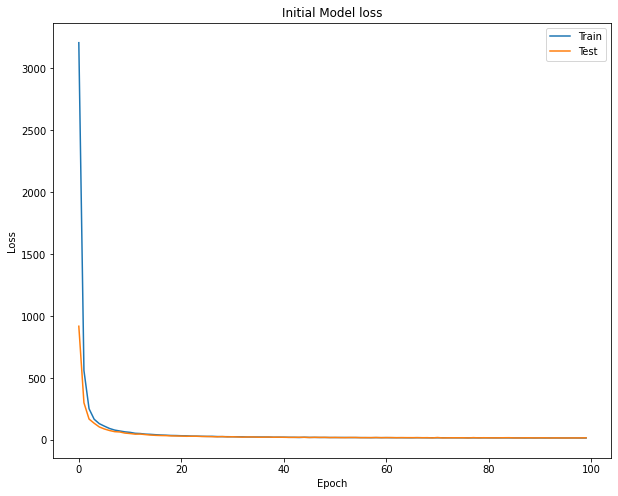

In [0]:
 # 訓練歷史可視化
import matplotlib.pyplot as plt
print("# list all data in history:",history_initial.history.keys())
# summarize history for loss plt.plot(history.history['loss']) plt.plot(history.history['val_loss']) plt.title('model loss')
plt.figure(figsize=(10,8))
plt.plot(history_initial.history['loss'])
plt.plot(history_initial.history['val_loss'])
plt.title('Initial Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("Initial_Loss.png")
plt.show()

## 3.3.1 第二階段訓練辨識模型

第二階段訓練，對整個網路訓練

In [0]:
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
# 第二階段，使用第一階段以訓練完成的網路權重繼續訓練：
# 將全部的權重都設置為可訓練，而在第一階段中，則是凍結部分權重
# 優化器不變，但是學習率下降
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    # 在Python generator逐批生成的數據上訓練模型。
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    # 模型fit數據，使用數據生成包裝器（data_generator_wrapper），按批次生成訓練與驗證數據，最终，模型model儲存權重。
    # 在Python generator逐批生成的數據上訓練模型。
    history_final =  model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes), # 生成器或Sequence （keras.utils.Sequence）對象的實例，以便在使用多重處理時避免重複數據。
        steps_per_epoch=max(1, num_train//batch_size), # steps_per_epoch：整數。generator在宣布一個epoch完成並開始下一個epoch之前要產生的總步數（一批樣品）。
        validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes), # 在每個時期結束時評估損失和任何模型指標。該模型將不會根據此數據進行訓練。
        validation_steps=max(1, num_val//batch_size), # 僅當validation_data 是生成器時才相關。validation_data在每個epoch結束之前停止產生之前要從生成器產生的步驟總數（樣本批次）。它通常應等於驗證數據集的樣本數除以批次大小。
        verbose=1, # 日誌顯示，0為不在標準輸出流輸出日誌資訊，1為輸出進度條記錄，2為每個epoch輸出一行記錄
        epochs=600, # 訓練模型的時期數。時期是對所提供的全部數據的迭代，
        initial_epoch=50, # 開始訓練的時期（用於恢復以前的訓練運行）
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        # reduce_lr:當評價指標不再提升时，减少學習率，每次减少10%（factor），當學習率3次未减少（patience）時，終止訓練。
        # early_stopping：驗證集損失值，連續增加小於0时，持續10個epoch，則終止訓練。
    model.save_weights(log_dir + 'trained_weights_final.h5') # 將權重存到 trained_weights_final.h5檔案

Unfreeze all of the layers.
Train on 291 samples, val on 73 samples, with batch size 16.
Epoch 51/600
18/18 [==============================] - 41s 2s/step - loss: 14.2138 - val_loss: 16.3077
Epoch 52/600
18/18 [==============================] - 22s 1s/step - loss: 13.7334 - val_loss: 15.4393
Epoch 53/600
18/18 [==============================] - 27s 1s/step - loss: 13.7988 - val_loss: 15.1493
Epoch 54/600
18/18 [==============================] - 27s 1s/step - loss: 13.5440 - val_loss: 17.3843
Epoch 55/600
18/18 [==============================] - 26s 1s/step - loss: 13.5968 - val_loss: 15.9588
Epoch 56/600
18/18 [==============================] - 26s 1s/step - loss: 13.6851 - val_loss: 16.7671

Epoch 00056: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 57/600
18/18 [==============================] - 23s 1s/step - loss: 13.8223 - val_loss: 16.0511
Epoch 58/600
18/18 [==============================] - 26s 1s/step - loss: 13.0477 - val_loss: 16.0623
Epoch 59/600
1

# 3.3.2 第二階段訓練結果可視化

# list all data in history: dict_keys(['val_loss', 'loss', 'lr'])


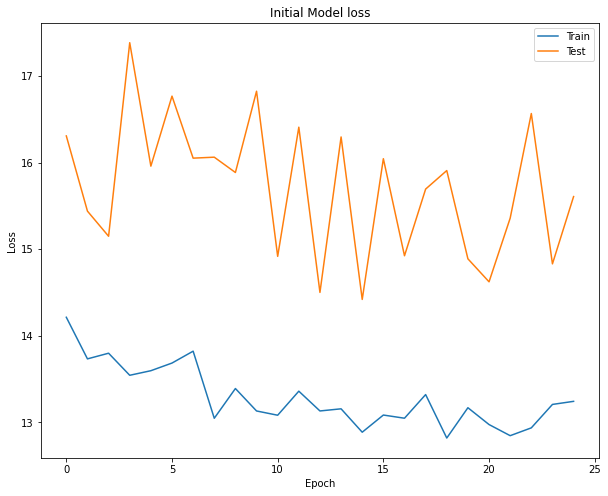

In [0]:
print("# list all data in history:",history_final.history.keys())
# summarize history for loss plt.plot(history.history['loss']) plt.plot(history.history['val_loss']) plt.title('model loss')
plt.figure(figsize=(10,8))
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('Initial Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("Final_Loss.png")
plt.show()

#4. 訓練結果
隨機讀取"racoon" 與 "kangaroo"的圖片進行YOLO檢測，觀看檢測結果。

raccon 目錄: raccoon_dataset/images
raccoon 檔案數量: 200

kangaroo 目錄: kangaroo/images
kangaroo 檔案數量: 164












logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (5, 2) (177, 200)
3.501207690000001


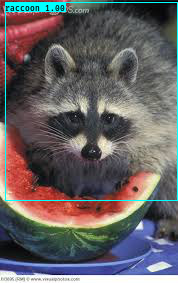

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (66, 143) (350, 640)
0.05471351299991056


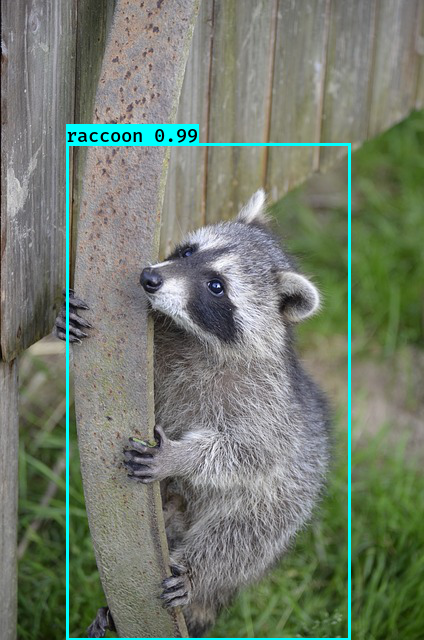

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (63, 88) (294, 256)
0.0470269920000419


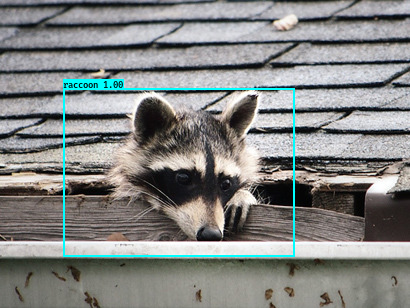

(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (201, 45) (695, 398)
0.07543846499993379


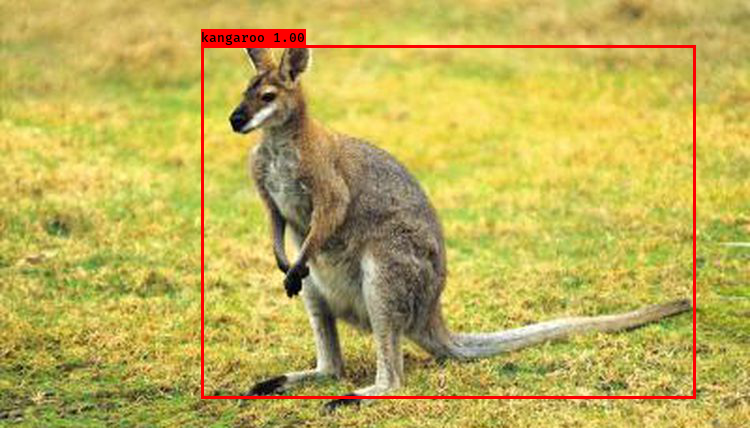

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.89 (130, 146) (434, 262)
kangaroo 1.00 (28, 91) (280, 278)
0.07924345599997196


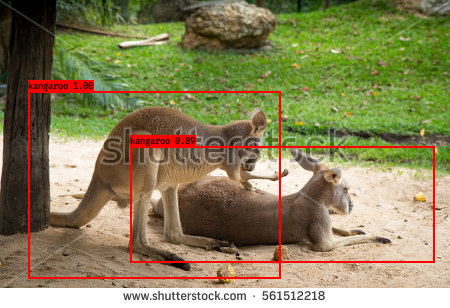

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (402, 124) (951, 466)
0.09093322299997908


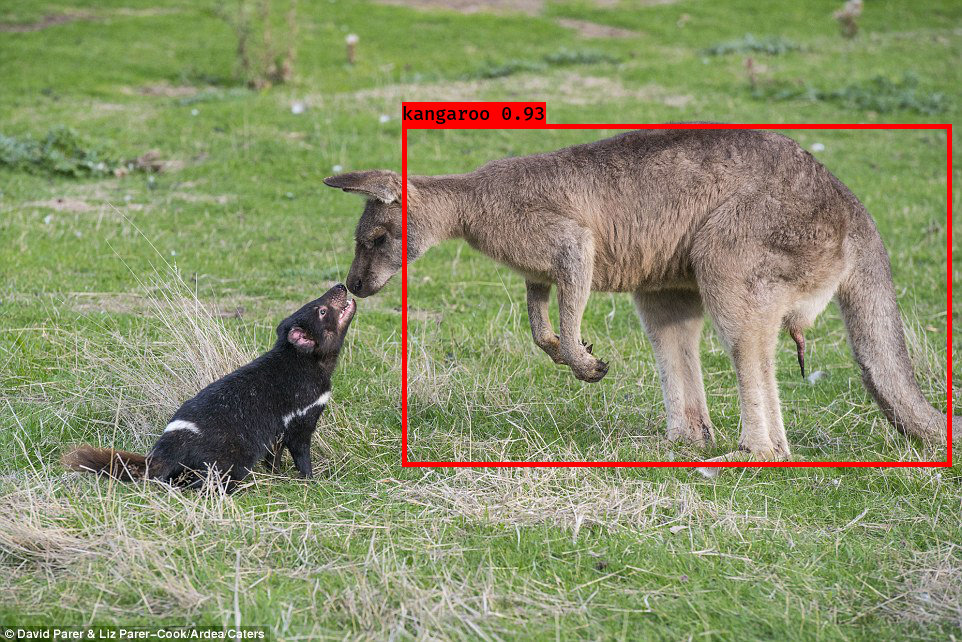

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (245, 74) (549, 434)
0.07965388200000234


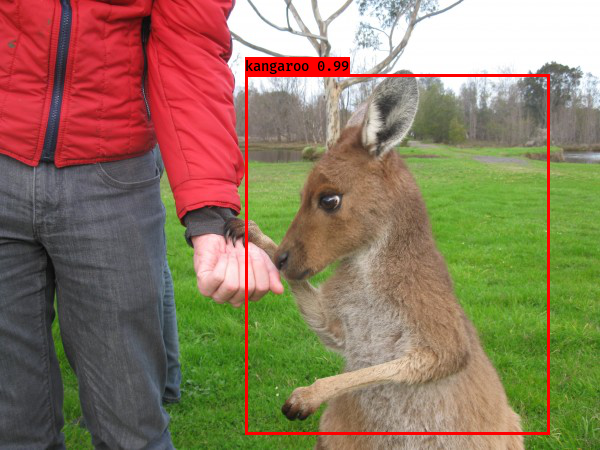

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (77, 265) (119, 309)
kangaroo 0.71 (281, 259) (326, 362)
kangaroo 0.83 (518, 367) (635, 443)
0.0957408999998961


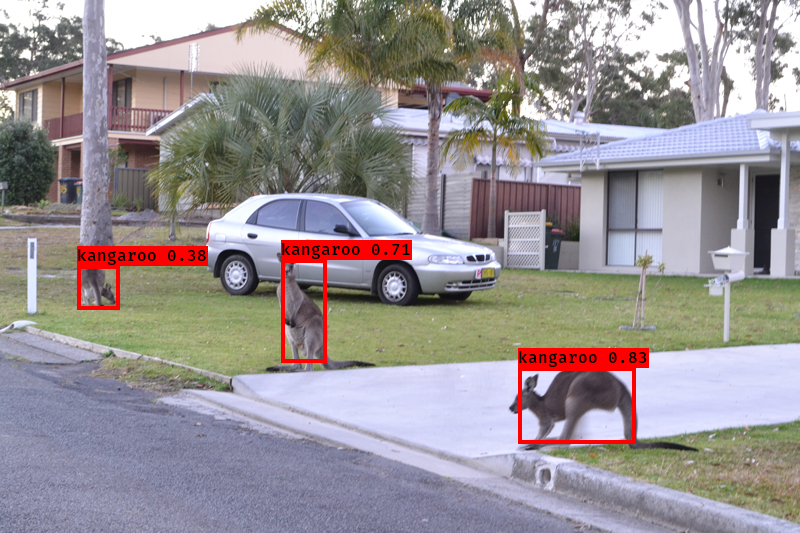

In [0]:
#讀取資料圖片，隨機抓取並進行彙整
for root_r,dirs_r,files_r in os.walk('raccoon_dataset/images') :  #os.walk():搜索所有的資料夾
  print("raccon 目錄:",root_r)
  print('raccoon 檔案數量:', len(files_r))
  print() # 空一行
for root_k,dirs_k,files_k in os.walk('kangaroo/images') : #os.walk():搜索所有的資料夾
  print("kangaroo 目錄:",root_k)
  print('kangaroo 檔案數量:', len(files_k))
Testimg_raccon = np.random.choice(files_r,size = 3)
Testimg_kangaroo = np.random.choice(files_k,size = 5)

#載入套件
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from yolo import YOLO

log_dir = 'logs/000/'
classes_path = 'class.txt'
yolo_model = YOLO(model_path= log_dir + 'trained_weights_final.h5', classes_path=classes_path)
#讀取raccon圖片
for i in Testimg_raccon:
  image1 = Image.open("raccoon_dataset/images/" + i)
  #顯示raccon圖片
  r_image1 = yolo_model.detect_image(image1)
  display(r_image1)
#讀取kangaroo圖片
for j in Testimg_kangaroo:
  image2 = Image.open("kangaroo/images/" + j)
  #顯示raccon圖片
  r_image2 = yolo_model.detect_image(image2)
  display(r_image2)

#5. 影像的辨識偵測
找出影片中的袋鼠與浣熊，參考https://github.com/Jordon-Chen/1st-DL-CVMarathon/blob/master/Day49_final_project.ipynb與yolo.py(def detect_video)的作法

In [0]:
# 偵測 Kangaroo.mp4 
from yolo import YOLO
import numpy as np
import time
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

classes_path = 'class.txt'
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑

yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

def detect_video(yolo, video_path, output_path=""):
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    # 指定 video 編碼方式(此例使用 MP4)
    video_FourCC = cv2.VideoWriter_fourcc(*'MP4V')
    video_fps       = vid.get(cv2.CAP_PROP_FPS) 
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    isOutput = True if output_path != "" else False
    if isOutput:
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    video_cnt = 0  
    video_playtime = []  
    while True:
        return_value, frame = vid.read()
        video_cnt += 1 
        if return_value == True : 
            image = Image.fromarray(frame)
            start_time = time.time() 
            image = yolo.detect_image(image)
            end_time = time.time()
            time_img = end_time - start_time  
            video_playtime.append(round(time_img, 3)) 
            result = np.asarray(image)
            cv2.putText(result, text='fps', org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.50, color=(255, 0, 0), thickness=2)
            if isOutput:
                out.write(result)
        else :  
            break
    vid.release()  # release vid resource
    out.release()  # release out resource
    return video_playtime, video_cnt 

# 1.偵測 Kangaroo.mp4
video_playtime, video_cnt = detect_video(yolo_model, video_path="video/Kangaroo.mp4", output_path="video/Kangaroo_new.mp4")
print('Kangaroo.mp4 total frames: ', video_cnt)  # 總共有多少 frames
print()#換行
# Kangaroo 平均 fps :
avg_fps = 1/np.mean(video_playtime)
print("Kangaroo.mp4 avg fps: %.3f" % avg_fps)
print() #換行
# 2.偵測 Raccoon.mp4
video_playtime, video_cnt = detect_video(yolo_model, video_path="video/Raccoon.mp4", output_path="video/Raccoon_new.mp4")
print('Raccoon.mp4 total frames: ', video_cnt)  # 總共有多少 frames
print() #換行
# Raccoon 平均 fps :
avg_fps = 1/np.mean(video_playtime)
print("Raccoon.mp4 avg fps: %.3f" % avg_fps)

Streaming output truncated to the last 5000 lines.
(416, 416, 3)
Found 0 boxes for img
0.051057283999966785
(416, 416, 3)
Found 0 boxes for img
0.05017257999998037
(416, 416, 3)
Found 0 boxes for img
0.05135591200007639
(416, 416, 3)
Found 0 boxes for img
0.0538722940000298
(416, 416, 3)
Found 0 boxes for img
0.05505828399998336
(416, 416, 3)
Found 0 boxes for img
0.05610424500002864
(416, 416, 3)
Found 0 boxes for img
0.05187088800005313
(416, 416, 3)
Found 0 boxes for img
0.04989525700000286
(416, 416, 3)
Found 0 boxes for img
0.05015659200000755
(416, 416, 3)
Found 0 boxes for img
0.050254574999939905
(416, 416, 3)
Found 0 boxes for img
0.05056404099991596
(416, 416, 3)
Found 0 boxes for img
0.049369046000038
(416, 416, 3)
Found 0 boxes for img
0.05480771400004869
(416, 416, 3)
Found 0 boxes for img
0.05022032199997284
(416, 416, 3)
Found 0 boxes for img
0.050140386999942166
(416, 416, 3)
Found 0 boxes for img
0.04994697899996936
(416, 416, 3)
Found 0 boxes for img
0.052252152000050

# 6.mAP 評估
參考來源:

(1): https://www.pythonf.cn/read/23845

(2): https://blog.csdn.net/plsong_csdn/article/details/89502117

(3): https://blog.csdn.net/qq_43211132/article/details/102988139

## 6.1 批量測試圖片

進行批量測試並保存結果

In [10]:
# 載入所需要套件
import colorsys
import os
from timeit import default_timer as timer
import time

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
from keras.utils import multi_gpu_model
#---------------------------------------------------------------------------------------------------------------------------
#指定待檢測圖片之路徑位置
path = 'Test/'  #待檢測圖片的路徑 (此部分為作者預設，使用者依情況調整)

# 建立一個儲存檢測結果之路徑
result_path = "Test/result" #(此部分為作者預設，使用者依情況調整)
# 檢查路徑是否存在
if not os.path.exists(result_path):
    os.makedirs(result_path) #os.makedirs():創建一個目錄

# result如果之前存放的有文件，則全部清除
for i in os.listdir(result_path): #os.listdir() 方法用於返回指定的文件夾包含的文件或文件夾的名字的列表。
    path_file = os.path.join(result_path,i)  # os.path.join():將多個路徑組合後返回
    if os.path.isfile(path_file): # os.path.isfile()檢查檔案是否存在
        os.remove(path_file) # os.remove() 方法用於刪除指定路徑的文件

#建立一個紀錄檢測結果之文件(.txt)
txt_path =result_path + '/result.txt'
file = open(txt_path,'w')  
#--------------------------------------------------------------------------------------------------------------------------
class YOLO(object):
    _defaults = {
        "model_path": 'logs/000/trained_weights_final.h5', #訓練好的模型
        "anchors_path": 'model_data/yolo_anchors.txt', #錨點定義檔路徑及名稱
        "classes_path": 'class.txt',  #自定義標籤檔路徑及名稱
        "score" : 0.3, # score 閥值(預設值為0.3)
        "iou" : 0.45, # iou 閥值(預設值為0.45)
        "model_image_size" : (416, 416), # 輸入圖片尺寸(416 x 416)
        "gpu_num" : 1, # gpu 數量
    }

    @classmethod
    # 讀取預設值（上邊的信息）
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    # def __init__(self, **kwargs):建立預設值，更新使用者覆蓋，獲取類別名稱、anchor，獲取keras已經建立的session、boxes.score、類別。
    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class() # 獲取類別名稱
        self.anchors = self._get_anchors() # anchor
        self.sess = K.get_session() # 獲取keras 建立的session
        self.boxes, self.scores, self.classes = self.generate() # 由「generator()」函數完成目標檢測
    
    # def _get_class(self):通過讀取類別文件獲取類別名。
    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)  #把path中包含的"~"和"~user"轉換成使用者目錄
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names] #預設刪除字串頭與字串尾的空格與换行符號
        return class_names

    #def _get_anchors(self):和類別相似，讀取anchor文件中的數據。
    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self): 
        model_path = os.path.expanduser(self.model_path) # 獲取model路徑
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.' #判斷model是否以h5结尾

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors) # num_anchors = 9。yolov3有9個檢驗框
        num_classes = len(self.class_names) # num_cliasses = 80。 #coco集一共80個類別
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes)                 if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            #[-1]:網路最後一層输出。 output_shape[-1]:輸出維度的最後一維。
            # 255 = 9/3*(80+5). 9/3:每層特徵圖對應3個anchor box  80:80個類别 5:4+1,框的4個值+1個置信度
            assert self.yolo_model.layers[-1].output_shape[-1] ==                 num_anchors/len(self.yolo_model.output) * (num_classes + 5),                 'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        # 生成繪製邊框的顏色。
        # h(色調）：x/len(self.class_names)  s(飽和度）：1.0  v(明亮）：1.0
 
        # 對於80種coco目標，確定每一種目標框的繪製顏色，即：將(x/80, 1.0, 1.0)的顏色轉換為RGB格式，並隨機調整顏色以便於肉眼辨識，
        # 其中：一個1.0表示飽和度，一個1.0表示亮度
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            # hsv取值範圍在【0,1】，而RBG取值範圍在【0,255】，所以乘上255
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs. # np.random.seed():產生隨機種子，固定種子為一致的顏色
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes. # 調整顏色来裝飾相鄰的類別
        np.random.seed(None)  # Reset seed to default. #重置種子為預設

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, )) # K.placeholder:keras中的占位符  相當於分配空間
        # shape = (2,) 代表該張量有一個維度，第一個維度長度為2，一堆數組1行2列
        
        # 若GPU個數大於等於2，调用multi_gpu_model()
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors, # yolo_eval():yolo評估函數
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes
    
    # detect_image作用：
    #要求進行檢測的圖片尺寸是32的倍數，原因：在網路中，執行的是5次步長為2的捲積操作，即
    #圖片的預設尺寸是416*416，因為在最底層中的特徵圖大小是13*13，所以13*32=416
    def detect_image(self, image):
        start = timer() # 開始計時
        
        # 調用letterbox_image()函數，即：先生成一個用"绝对灰"R128-G128-B128"填充的416x416新圖片，
        # 然後使用按比例縮放（採樣方法：BICUBIC）後的輸入圖片黏貼，黏貼不到的部分保留為灰色
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            # assert斷言语句的語法格式 model_image_size[0][1]指圖像的w和h，且必须是32的整數倍
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape) #輸出圖片尺寸 416，416,3）
        image_data /= 255. # 將縮放後圖片的數值除以255，做歸一化
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
        #批量添加一维 -> (1,416,416,3) 為了符合網路的輸入格式 -> (bitch, w, h, c)

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            #目的為了求boxes,scores,classes，具體計算方式定義在generate（）函數內。在yolo.py第61行
            feed_dict={
                self.yolo_model.input: image_data, #圖像數據
                self.input_image_shape: [image.size[1], image.size[0]], #圖像尺寸416x416
                K.learning_phase(): 0 #學習模式 0：測試模型。 1：訓練模型
            })

        # 繪製邊框，自動設置邊框寬度、繪製邊框與類別文字
        print('Found {} boxes for {}'.format(len(out_boxes), 'img')) # 提示用於找到幾個bbox
        # 設置字體
        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(2e-2 * image.size[1] + 0.2).astype('int32'))
        # 設置目標框線條的寬度
        thickness = (image.size[0] + image.size[1]) // 300 #厚度

        # 保存框檢測出的框個數
        file.write('find  '+str(len(out_boxes))+' target(s) \n')

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c] # 類別  # 目標類別的名字
            box = out_boxes[i] # 框
            score = out_scores[i]  # 置信度

            label = '{} {:.2f}'.format(predicted_class, score) # 標籤
            draw = ImageDraw.Draw(image) #輸出：繪製輸入的原始圖片
            label_size = draw.textsize(label, font) #標籤文字   #返回label的寬與高（多少個pixels）

            top, left, bottom, right = box
            # 目標框的上、左兩個座標小數點後一位四捨五入
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            # 目標框的下、右兩個座標小數點後一位四捨五入，與圖片的尺寸相比，取最小值
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            
            #此段目的為做mAP指標計算前資料準備用
            # 寫入檢測的位置，其格式為:
            # <classname>、score、left、top、right、bottom
            file.write(predicted_class+'  score: '+str(score)+' \nlocation: top: '+str(top)+'、 bottom: '+str(bottom)+'、 left: '+str(left)+'、 right: '+str(right)+'\n')
            
            print(label, (left, top), (right, bottom))  # 邊框
            
            # 確定標籤（label）起始點位置：左、下
            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            # 畫目標框，先調寬度為thickness
            for i in range(thickness):  # 畫框
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            # 畫標籤框
            draw.rectangle( #文字背景
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            # 填寫標籤內容
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw
        
        # 結束計時
        end = timer()
        print('time consume:%.3f s '%(end - start))
        return image

    def close_session(self):
        self.sess.close()
#--------------------------------------------------------------------------------------------------------------------------

# 圖片檢測
if __name__ == '__main__':

    t1 = time.time() # time.time()返回當前時間的時間戳
    yolo = YOLO()   
    for filename in os.listdir("Test/images/"):   #os.listdir() 方法用於返回指定的文件夾包含的文件或文件夾的名字的列表。      
        print(filename)
        file.write(filename+' detect_result：\n')  
        Figpath = "Test/images/"      
        image = Image.open(Figpath + filename )
        r_image = yolo.detect_image(image)
        print(r_image)
        file.write('\n')
        r_image.show() # 顯示檢測結果
        image_save_path = 'Test/result/result_'+ filename       
        print('detect result save to....:'+image_save_path)
        r_image.save(image_save_path)

    time_sum = time.time() - t1 # time.time()返回當前時間的時間戳
    file.write('time sum: '+str(time_sum)+'s') 
    print('time sum:',time_sum)
    file.close() 
    yolo.close_session()


logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Test-19.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (27, 17) (269, 180)
time consume:2.639 s 
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=269x187 at 0x7FD21555ABA8>
detect result save to....:Test/result/result_Test-19.jpg
Test-16.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (55, 9) (310, 155)
time consume:0.064 s 
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=310x163 at 0x7FD21553D4E0>
detect result save to....:Test/result/result_Test-16.jpg
Test-18.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (20, 3) (931, 492)
time consume:0.077 s 
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=931x524 at 0x7FD215532C88>
detect result save to....:Test/result/result_Test-18.jpg
Test-4.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (57, 29) (205, 182)
time consume:0.062 s 
<PIL.Jpeg

生成符合result.txt文件

In [11]:
import re
with open('Test/result/result.txt', 'r') as f:  # 打開文件
    filename = f.readlines()  # 讀取文件，依次讀取每一行
    print(filename)
    print(len(filename))

['Test-19.jpg detect_result：\n', 'find  1 target(s) \n', 'raccoon  score: 0.9991444 \n', 'location: top: 17、 bottom: 180、 left: 27、 right: 269\n', '\n', 'Test-16.jpg detect_result：\n', 'find  1 target(s) \n', 'raccoon  score: 0.9868443 \n', 'location: top: 9、 bottom: 155、 left: 55、 right: 310\n', '\n', 'Test-18.jpg detect_result：\n', 'find  1 target(s) \n', 'raccoon  score: 0.99972713 \n', 'location: top: 3、 bottom: 492、 left: 20、 right: 931\n', '\n', 'Test-4.jpg detect_result：\n', 'find  1 target(s) \n', 'raccoon  score: 0.9885279 \n', 'location: top: 29、 bottom: 182、 left: 57、 right: 205\n', '\n', 'Test-8.jpg detect_result：\n', 'find  1 target(s) \n', 'raccoon  score: 0.79513 \n', 'location: top: 32、 bottom: 197、 left: 14、 right: 213\n', '\n', 'Test-9.jpg detect_result：\n', 'find  2 target(s) \n', 'kangaroo  score: 0.5588154 \n', 'location: top: 11、 bottom: 248、 left: 0、 right: 177\n', 'raccoon  score: 0.60353816 \n', 'location: top: 5、 bottom: 255、 left: 0、 right: 189\n', '\n', 'Tes

## 6.2 mAP 計算前準備
準備計算MAP需要detection-results，ground-truth、images-optional


In [12]:
# 載入所需要套件
import colorsys
import os
from timeit import default_timer as timer
import time

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
from keras.utils import multi_gpu_model
#---------------------------------------------------------------------------------------------------------------------------
#指定待檢測圖片之路徑位置
path = 'mAP/'  #待檢測圖片的路徑 (此部分為作者預設，使用者依情況調整)

# 建立一個儲存檢測結果之路徑
result_path = "mAP/result" #(此部分為作者預設，使用者依情況調整)
# 檢查路徑是否存在
if not os.path.exists(result_path):
    os.makedirs(result_path) #os.makedirs():創建一個目錄

# result如果之前存放的有文件，則全部清除
for i in os.listdir(result_path): #os.listdir() 方法用於返回指定的文件夾包含的文件或文件夾的名字的列表。
    path_file = os.path.join(result_path,i)  # os.path.join():將多個路徑組合後返回
    if os.path.isfile(path_file): # os.path.isfile()檢查檔案是否存在
        os.remove(path_file) # os.remove() 方法用於刪除指定路徑的文件

#建立一個紀錄檢測結果之文件(.txt)
txt_path =result_path + '/result.txt'
file = open(txt_path,'w')  
#--------------------------------------------------------------------------------------------------------------------------
class YOLO(object):
    _defaults = {
        "model_path": 'logs/000/trained_weights_final.h5', #訓練好的模型
        "anchors_path": 'model_data/yolo_anchors.txt', #錨點定義檔路徑及名稱
        "classes_path": 'class.txt',  #自定義標籤檔路徑及名稱
        "score" : 0.3, # score 閥值(預設值為0.3)
        "iou" : 0.45, # iou 閥值(預設值為0.45)
        "model_image_size" : (416, 416), # 輸入圖片尺寸(416 x 416)
        "gpu_num" : 1, # gpu 數量
    }

    @classmethod
    # 讀取預設值（上邊的信息）
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    # def __init__(self, **kwargs):建立預設值，更新使用者覆蓋，獲取類別名稱、anchor，獲取keras已經建立的session、boxes.score、類別。
    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class() # 獲取類別名稱
        self.anchors = self._get_anchors() # anchor
        self.sess = K.get_session() # 獲取keras 建立的session
        self.boxes, self.scores, self.classes = self.generate() # 由「generator()」函數完成目標檢測
    
    # def _get_class(self):通過讀取類別文件獲取類別名。
    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)  #把path中包含的"~"和"~user"轉換成使用者目錄
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names] #預設刪除字串頭與字串尾的空格與换行符號
        return class_names

    #def _get_anchors(self):和類別相似，讀取anchor文件中的數據。
    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self): 
        model_path = os.path.expanduser(self.model_path) # 獲取model路徑
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.' #判斷model是否以h5结尾

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors) # num_anchors = 9。yolov3有9個檢驗框
        num_classes = len(self.class_names) # num_cliasses = 80。 #coco集一共80個類別
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes)                 if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            #[-1]:網路最後一層输出。 output_shape[-1]:輸出維度的最後一維。
            # 255 = 9/3*(80+5). 9/3:每層特徵圖對應3個anchor box  80:80個類别 5:4+1,框的4個值+1個置信度
            assert self.yolo_model.layers[-1].output_shape[-1] ==                 num_anchors/len(self.yolo_model.output) * (num_classes + 5),                 'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        # 生成繪製邊框的顏色。
        # h(色調）：x/len(self.class_names)  s(飽和度）：1.0  v(明亮）：1.0
 
        # 對於80種coco目標，確定每一種目標框的繪製顏色，即：將(x/80, 1.0, 1.0)的顏色轉換為RGB格式，並隨機調整顏色以便於肉眼辨識，
        # 其中：一個1.0表示飽和度，一個1.0表示亮度
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            # hsv取值範圍在【0,1】，而RBG取值範圍在【0,255】，所以乘上255
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs. # np.random.seed():產生隨機種子，固定種子為一致的顏色
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes. # 調整顏色来裝飾相鄰的類別
        np.random.seed(None)  # Reset seed to default. #重置種子為預設

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, )) # K.placeholder:keras中的占位符  相當於分配空間
        # shape = (2,) 代表該張量有一個維度，第一個維度長度為2，一堆數組1行2列
        
        # 若GPU個數大於等於2，调用multi_gpu_model()
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors, # yolo_eval():yolo評估函數
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes
    
    # detect_image作用：
    #要求進行檢測的圖片尺寸是32的倍數，原因：在網路中，執行的是5次步長為2的捲積操作，即
    #圖片的預設尺寸是416*416，因為在最底層中的特徵圖大小是13*13，所以13*32=416
    def detect_image(self, image):
        start = timer() # 開始計時
        
        # 調用letterbox_image()函數，即：先生成一個用"绝对灰"R128-G128-B128"填充的416x416新圖片，
        # 然後使用按比例縮放（採樣方法：BICUBIC）後的輸入圖片黏貼，黏貼不到的部分保留為灰色
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            # assert斷言语句的語法格式 model_image_size[0][1]指圖像的w和h，且必须是32的整數倍
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape) #輸出圖片尺寸 416，416,3）
        image_data /= 255. # 將縮放後圖片的數值除以255，做歸一化
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
        #批量添加一维 -> (1,416,416,3) 為了符合網路的輸入格式 -> (bitch, w, h, c)

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            #目的為了求boxes,scores,classes，具體計算方式定義在generate（）函數內。在yolo.py第61行
            feed_dict={
                self.yolo_model.input: image_data, #圖像數據
                self.input_image_shape: [image.size[1], image.size[0]], #圖像尺寸416x416
                K.learning_phase(): 0 #學習模式 0：測試模型。 1：訓練模型
            })

        # 繪製邊框，自動設置邊框寬度、繪製邊框與類別文字
        print('Found {} boxes for {}'.format(len(out_boxes), 'img')) # 提示用於找到幾個bbox
        # 設置字體
        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(2e-2 * image.size[1] + 0.2).astype('int32'))
        # 設置目標框線條的寬度
        thickness = (image.size[0] + image.size[1]) // 300 #厚度

        # 保存框檢測出的框個數
        # file.write('find  '+str(len(out_boxes))+' target(s) \n')

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c] # 類別  # 目標類別的名字
            box = out_boxes[i] # 框
            score = out_scores[i]  # 置信度

            label = '{} {:.2f}'.format(predicted_class, score) # 標籤
            draw = ImageDraw.Draw(image) #輸出：繪製輸入的原始圖片
            label_size = draw.textsize(label, font) #標籤文字   #返回label的寬與高（多少個pixels）

            top, left, bottom, right = box
            # 目標框的上、左兩個座標小數點後一位四捨五入
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            # 目標框的下、右兩個座標小數點後一位四捨五入，與圖片的尺寸相比，取最小值
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            
            #此段目的為做mAP指標計算前資料準備用
            # 寫入檢測的位置，其格式為:
            # <classname>、score、left、top、right、bottom
            # file.write(predicted_class+'  score: '+str(score)+' \nlocation: top: '+str(top)+'、 bottom: '+str(bottom)+'、 left: '+str(left)+'、 right: '+str(right)+'\n')
            file.write(""+ predicted_class +" "+str(score)+" "+str(left)+" "+str(top)+" "+str(right)+" "+str(bottom)+";")
            
            print(label, (left, top), (right, bottom))  # 邊框
            
            # 確定標籤（label）起始點位置：左、下
            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            # 畫目標框，先調寬度為thickness
            for i in range(thickness):  # 畫框
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            # 畫標籤框
            draw.rectangle( #文字背景
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            # 填寫標籤內容
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw
        
        # 結束計時
        end = timer()
        print('time consume:%.3f s '%(end - start))
        return image

    def close_session(self):
        self.sess.close()
#--------------------------------------------------------------------------------------------------------------------------

# 圖片檢測
if __name__ == '__main__':
    t1 = time.time() # time.time()返回當前時間的時間戳
    yolo = YOLO()   
    for filename in os.listdir("mAP/input/images-optional/"):   #os.listdir() 方法用於返回指定的文件夾包含的文件或文件夾的名字的列表。      
        print(filename)
        file.write("mAP/input/images-optional/" + filename + " ")  
        Figpath = "mAP/input/images-optional/"      
        image = Image.open(Figpath + filename )
        r_image = yolo.detect_image(image)
        print(r_image)
        file.write('\n')
        r_image.show() # 顯示檢測結果
        image_save_path = 'mAP/result/result_'+ filename       
        print('detect result save to....:'+image_save_path)
        print() # 空一行
        r_image.save(image_save_path)

    time_sum = time.time() - t1 # time.time()返回當前時間的時間戳
    # file.write('time sum: '+str(time_sum)+'s') 
    print('time sum:',time_sum)
    file.close() 
    yolo.close_session()


logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
00039.jpg
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.77 (173, 11) (335, 299)
kangaroo 0.98 (291, 53) (459, 268)
time consume:1.664 s 
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x338 at 0x7FE0F0846A20>
detect result save to....:mAP/result/result_00039.jpg

00038.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (208, 14) (436, 280)
time consume:0.072 s 
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x320 at 0x7FE0F0877E10>
detect result save to....:mAP/result/result_00038.jpg

00043.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (51, 6) (467, 397)
time consume:0.080 s 
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=642x397 at 0x7FE0F0846A20>
detect result save to....:mAP/result/result_00043.jpg

00033.jpg
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (263, 28) (621, 296)
time consume:0.075 s 
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=634x357 at 0x7FE0F2

### 6.2.1製作detection-results
detection-results文件夾裡面放的測試結果，要求將每一張圖片的測試結果存放為一個txt文件

格式是： score left top right bottom

In [13]:
import re
with open("mAP/input/detection-results/result.txt", 'r') as f:  # 打開文件
    filename = f.readlines()  # 讀取文件，依次讀取每一行
    print(filename,"\n")
for i in range(len(filename)):
    # re.sub功能是對於一個輸入的字符串，利用正則表達式，來實現字符串替換處理的功能返回處理後的字符串
    filename[i] = re.sub('mAP/input/images-optional/','',filename[i])        # 去除文件名稱多餘的部分
for i in range(len(filename)):  # 中按行存放的檢測内容，為列表的形式
    r = filename[i].split('.jpg ') # split() 通過指定分隔符號對字符串進行切片
    print(r)
    file = open('mAP/input/detection-results/' + r[0] + '.txt', 'w')
    t = r[1].split(';') # split() 通過指定分隔符號對字符串進行切片
    # 去除空格和换行
    if i != len(filename):
      t.remove('\n') # remove() 函數用於移除列表中某個值的第一個匹配項。
      print(t)
      if len(t) == 0:            # 如果没有对象
          file.write('')
      else:
          for k in range(len(t)):
              file.write(t[k] + '\n')

['mAP/input/images-optional/00039.jpg kangaroo 0.77015215 173 11 335 299;kangaroo 0.979183 291 53 459 268;\n', 'mAP/input/images-optional/00038.jpg kangaroo 0.9911253 208 14 436 280;\n', 'mAP/input/images-optional/00043.jpg kangaroo 0.9963618 51 6 467 397;\n', 'mAP/input/images-optional/00033.jpg kangaroo 0.99786735 263 28 621 296;\n', 'mAP/input/images-optional/00034.jpg kangaroo 0.9954293 0 135 242 440;\n', 'mAP/input/images-optional/00037.jpg kangaroo 0.805706 291 51 397 322;kangaroo 0.9725668 27 114 266 372;\n', 'mAP/input/images-optional/00036.jpg kangaroo 0.45476496 274 89 519 266;kangaroo 0.84574705 694 21 792 308;kangaroo 0.9188485 398 127 775 321;kangaroo 0.98498565 196 280 759 488;kangaroo 0.99654067 92 10 314 485;\n', 'mAP/input/images-optional/00042.jpg kangaroo 0.9958033 272 402 561 766;\n', 'mAP/input/images-optional/00041.jpg kangaroo 0.9279563 402 124 951 466;\n', 'mAP/input/images-optional/00040.jpg kangaroo 0.78040564 460 140 525 199;\n', 'mAP/input/images-optional/00

### 6.2.2 生成ground-truth

在上一步驟中已經生成了train_labels.txt檔案，現在要轉換成符合ground-truth格式要求的txt內容。

In [14]:
import re
with open("mAP/input/ground-truth/train_labels.txt", 'r') as f:  # 打開文件
    filename = f.readlines()  # 讀取文件，依次讀取每一行
for i in range(len(filename)):
    # re.sub功能是對於一個輸入的字符串，利用正則表達式，來實現字符串替換處理的功能返回處理後的字符串
    filename[i] = re.sub('images/','',filename[i])        # 去除文件名稱多餘的部分
for i in range(len(filename)):  # 中按行存放的檢測内容，為列表的形式
    r = filename[i].split('.jpg ') # split() 通過指定分隔符號對字符串進行切片
    print(r)
    file = open('mAP/input/ground-truth/' + r[0] + '.txt', 'w')
    t = r[1].split(';') # split() 通過指定分隔符號對字符串進行切片
    print("t內容:",t)
    print()# 換行
    # 去除空格和换行
    for j in range(len(t)):
      class_t = t[j].split(',')[-1]
      print("calss_t內容:",class_t)
      pos_t = t[j].split(',')
      print("pos_t內容",pos_t)
      if class_t == '0' or class_t == '0\n':
          file.write('raccoon ' + pos_t[0] + ' ' + pos_t[1] + ' '+ pos_t[2] + ' '+ pos_t[3] + '\n')
      elif class_t == '1' or class_t == '1\n':
          file.write('kangaroo ' + pos_t[0] + ' ' + pos_t[1] + ' '+ pos_t[2] + ' '+ pos_t[3] + '\n')

['00020', '98,28,592,472,1 508,302,561,373,1\n']
t內容: ['98,28,592,472,1 508,302,561,373,1\n']

calss_t內容: 1

pos_t內容 ['98', '28', '592', '472', '1 508', '302', '561', '373', '1\n']
['raccoon-197', '114,35,987,653,0\n']
t內容: ['114,35,987,653,0\n']

calss_t內容: 0

pos_t內容 ['114', '35', '987', '653', '0\n']
['raccoon-131', '1,1,199,184,0\n']
t內容: ['1,1,199,184,0\n']

calss_t內容: 0

pos_t內容 ['1', '1', '199', '184', '0\n']
['raccoon-157', '1,1,144,209,0\n']
t內容: ['1,1,144,209,0\n']

calss_t內容: 0

pos_t內容 ['1', '1', '144', '209', '0\n']
['00157', '508,268,618,477,1\n']
t內容: ['508,268,618,477,1\n']

calss_t內容: 1

pos_t內容 ['508', '268', '618', '477', '1\n']
['00059', '130,186,800,506,1\n']
t內容: ['130,186,800,506,1\n']

calss_t內容: 1

pos_t內容 ['130', '186', '800', '506', '1\n']
['00103', '272,113,367,273,1 19,84,271,274,1\n']
t內容: ['272,113,367,273,1 19,84,271,274,1\n']

calss_t內容: 1

pos_t內容 ['272', '113', '367', '273', '1 19', '84', '271', '274', '1\n']
['raccoon-25', '31,82,325,641,0\n']
t內容: [

### 6.2.3  計算mAP

In [10]:
# 執行main.py
%cd mAP

/content/gdrive/My Drive/深度學習與電腦視覺學習馬拉松-第二屆/Day_49-50/YOLOFinalProject/mAP


In [18]:
%matplotlib notebook
!python3 main.py

: cannot connect to X server 


# 參考資料(Reference) 

1. Day41_train_yolov3_Sample

2. https://github.com/andyhu00/1st-DL-CVMarathon/blob/master/1st-DL-CVMarathon_project.ipynb

3. https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/3.5-yolov2-train-hands-dataset.ipynb

4. https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242

5. https://github.com/Jordon-Chen/1st-DL-CVMarathon/blob/master/Day49_final_project.ipynb

6. https://www.cupoy.com/clubnews/ai_tw/0000016E62FABB7A000000016375706F795F72656C656173654B5741535354434C5542/00000170985DE1B6000000116375706F795F72656C656173654B5741535354434C55424E455753

7. https://www.pythonf.cn/read/23845
8. https://github.com/Cartucho/mAP